## Temporal Fusion Transformer: Time Series Forecasting with Deep Learning — Complete Tutorial
### Powe Usage real example

In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
import seaborn as sns

/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 1.0 Download the dataset

In [2]:
data = pd.read_csv("data/LD2011_2014.txt", index_col=0, sep=';', decimal=',')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [4]:
data.index = pd.to_datetime(data.index)

In [5]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Resampling das timeseries para hora

In [6]:
data = data.resample('1h').mean().replace(0., np.nan)

In [7]:
# Pega a data mínima
earliest_time = data.index.min()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35065 entries, 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Freq: H
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 99.3 MB


In [9]:
df=data[['MT_002', 'MT_004', 'MT_005', 'MT_006', 'MT_008' ]]

In [10]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
  
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

In [11]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


### EDA

In [12]:
time_df[["consumer_id", "power_usage"]].groupby("consumer_id").mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


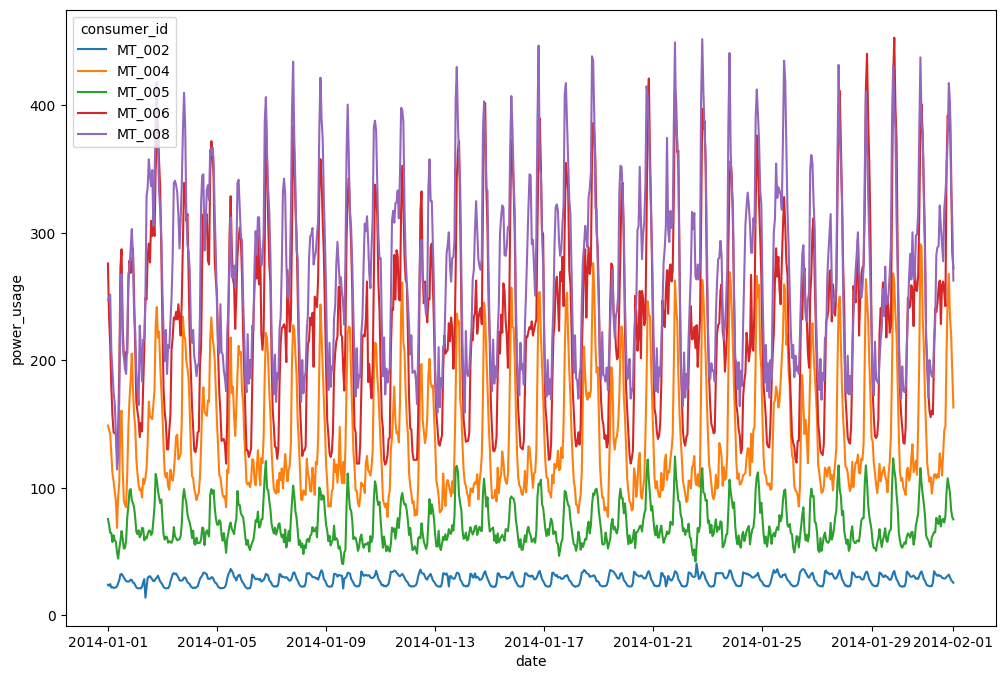

In [13]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=time_df[time_df['date'] <= pd.to_datetime('2014-02-01')],
    x="date",
    y="power_usage",
    hue='consumer_id',
    ax=axs
)
plt.show()

### Modelando

In [14]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length


In [15]:
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [16]:
validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [17]:
import torch
import pytorch_forecasting.models.baseline as bs 

In [18]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = bs.Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers whic

25.139617919921875

In [19]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer

from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics.quantile import QuantileLoss

In [20]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = Trainer(
    max_epochs=45,
    accelerator='cpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embedd

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/michel/anaconda3/envs/tft/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   4%|▍         | 19/468 [00:50<19:46,  2.64s/it, v_num=2, train_loss_step=26.10]

: 

: 

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
%load_ext tensorboard
%tensorboard - logdir lightning_logs

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

#6.067104816436768
#tensor([ 1.0064,  6.8266,  2.1732,  8.3614, 11.9679], device='cuda:0')

In [ ]:
#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

In [ ]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
